## Reduced model without AMPA, Wong and Wang 2006

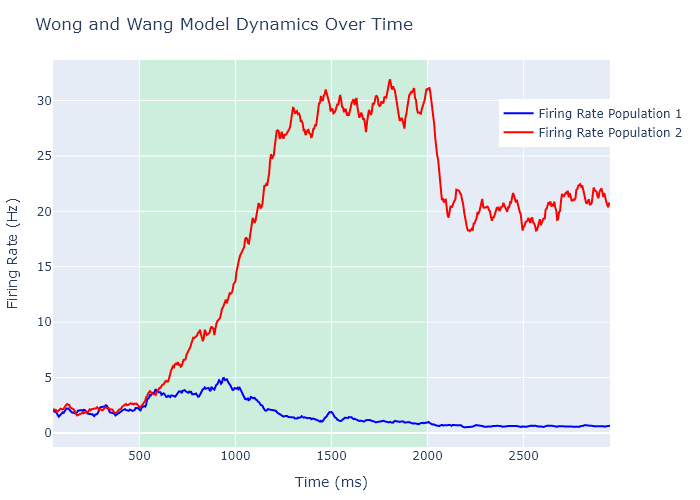

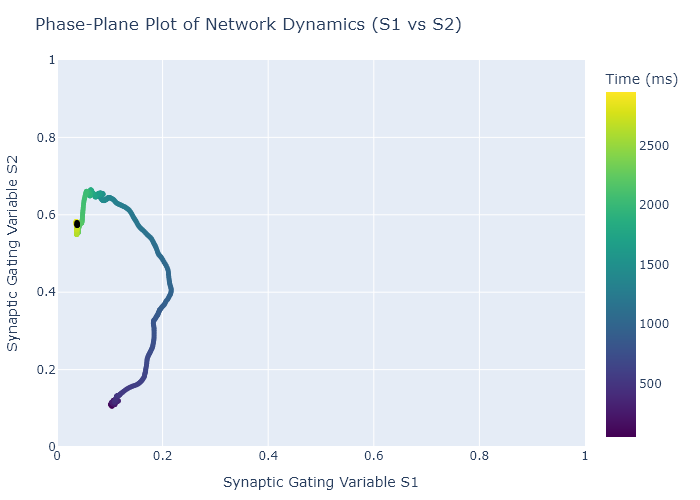

In [1]:
# Import necessary packages
using Random
using Statistics
using PlotlyJS

# Set random seed for reproducibility
Random.seed!(1234)

# Simulation Parameters
dt = 0.5                        # Time step (ms)
t_max = 3000.0                  # Total simulation time (ms)
time = 0.0:dt:t_max             # Time vector
n_time_steps = length(time)

# Model Parameters
# Time Constants
τ_NMDA = 100.0                  # NMDA synaptic time constant (ms)
τ_AMPA = 2.0                    # AMPA synaptic time constant (ms)

# Synaptic Efficacies
J_N = 0.2609                    # Recurrent NMDA excitation strength
J_N_cross = 0.0497              # Cross NMDA excitation


# NMDA Gain Factor
γ = 0.641                       # NMDA receptor gain factor



# External Inputs
I_0 = 0.3255                    # Baseline external input (nA)
μ0 = 30                         # Hz, mean input
J_Input = 5.2e-4                # Input excitation
coherence = 0.032               # Coherence level (0 to 1)
# Stimulus input to Population 1&2
I_stim_1 = J_Input * μ0 * (1 + coherence) 
I_stim_2 = J_Input * μ0 * (1 - coherence)

stim_start = 500.0              # Stimulus onset time (ms)
stim_end = 2000.0               # Stimulus offset time (ms)

# Noise Parameters
σ_I = 0.02                      # Reduced standard deviation of input noise (nA)

# Initialize variables
S1 = zeros(n_time_steps)        # Synaptic gating variable for Population 1
S2 = zeros(n_time_steps)        # Synaptic gating variable for Population 2

r1 = zeros(n_time_steps)        # Firing rate of Population 1
r2 = zeros(n_time_steps)        # Firing rate of Population 2

I1 = zeros(n_time_steps)        # Total input current to Population 1
I2 = zeros(n_time_steps)        # Total input current to Population 2

decision_made = false
decision_time = 0.0
choice = 0

# Define transfer function H(I)
# F-I Curve Parameters (Excitatory Neurons)
a = 270.0                       # (Hz/nA)
b = 108.0                       # (Hz)
d = 0.154                       # (s)
function H(I)
    I_eff = a * I - b
    #if I_eff <= 0
    #    return 0.0
    #else
        return I_eff / (1.0 - exp(-d * I_eff))
    #end
end

# Precompute external inputs
I_ext1 = fill(I_0, n_time_steps)
I_ext2 = fill(I_0, n_time_steps)

stim_indices = findall(t -> t >= stim_start && t <= stim_end, time)
I_ext1[stim_indices] .+= I_stim_1
I_ext2[stim_indices] .+= I_stim_2

# Simulate the network dynamics
I_noise1 = σ_I * randn()
I_noise2 = σ_I * randn()

S1[1] = S2[1] = 0.1
for t in 1:n_time_steps-1
    
    # Compute noise terms
    I_noise1 = I_noise1 + dt / τ_AMPA * (-I_noise1) + sqrt(dt/τ_AMPA) * σ_I * randn()
    I_noise2 = I_noise2 + dt / τ_AMPA * (-I_noise2) + sqrt(dt/τ_AMPA) * σ_I * randn()

    # Compute total input currents
    I1[t] = J_N * S1[t] - J_N_cross * S2[t] + I_ext1[t] + I_noise1
    I2[t] = J_N * S2[t] - J_N_cross * S1[t] + I_ext2[t] + I_noise2
    
    # Compute firing rates
    r1[t] = H(I1[t])
    r2[t] = H(I2[t])
    r1[t] = r1[t] < 0 ? 0 : r1[t]
    r2[t] = r2[t] < 0 ? 0 : r2[t]
    
    # Update synaptic gating variables using Euler method with gamma_NMDA
    S1[t+1] = S1[t] + (- S1[t] / τ_NMDA + (1 - S1[t]) * γ * r1[t] / 1000) * dt
    S2[t+1] = S2[t] + (- S2[t] / τ_NMDA + (1 - S2[t]) * γ * r2[t] / 1000) * dt
    
end


# Calculate mean rates and gating variables with sliding window
time_window = Int(50 / dt)                          # time window 50 ms
sliding_step = Int(5 / dt)                          # sliding window step 5 ms
r1_smooth = [mean(r1[1:time_window])]
r2_smooth = [mean(r2[1:time_window])]
S1_smooth = [mean(S1[1:time_window])]
S2_smooth = [mean(S2[1:time_window])]
for t in 1:Int(floor((n_time_steps - time_window) / sliding_step))
    start_idx = sliding_step * (t-1) + 1
    end_idx = sliding_step * (t-1) + time_window
    push!(r1_smooth, mean(r1[start_idx:end_idx]))
    push!(r2_smooth, mean(r2[start_idx:end_idx]))
    push!(S1_smooth, mean(S1[start_idx:end_idx]))
    push!(S2_smooth, mean(S2[start_idx:end_idx]))
end

# Visualization using PlotlyJS

# Plot firing rates over time
trace_r1 = scatter(
    x = dt*time_window:dt*sliding_step:dt*(n_time_steps - time_window),
    y = r1_smooth,
    mode = "lines",
    name = "Firing Rate Population 1",
    line = attr(color = "blue", width = 2)
)

trace_r2 = scatter(
    x = dt*time_window:dt*sliding_step:dt*(n_time_steps - time_window),
    y = r2_smooth,
    mode = "lines",
    name = "Firing Rate Population 2",
    line = attr(color = "red", width = 2)
)

# Create shape for stimulus period
stim_shape = [
    attr(
        type = "rect",
        xref = "x",
        yref = "paper",
        x0 = stim_start,
        y0 = 0,
        x1 = stim_end,
        y1 = 1,
        fillcolor = "rgba(0, 255, 0, 0.1)",
        line = attr(width = 0),
        layer = "below"
    )
]

# Create layout for time series plot
layout_time_series = Layout(
    title = "Wong and Wang Model Dynamics Over Time",
    xaxis = attr(title = "Time (ms)"),
    yaxis = attr(title = "Firing Rate (Hz)"),
    legend = attr(orientation = "v", x = 0.8, y = 0.9),
    shapes = stim_shape,
    height = 400
)

# Create figure for time series and display
fig_time_series = Plot([trace_r1, trace_r2], layout_time_series)

display(fig_time_series)

# Phase-plane Plot: Plot S1 vs S2
trace_phase_plane = scatter(
    x = S1_smooth,
    y = S2_smooth,
    mode = "lines+markers",
    marker = attr(
        color = Array(dt*time_window:dt*sliding_step:dt*(n_time_steps - time_window)),  # Color by time
        colorscale = "Viridis",
        size = 5,
        showscale = true,
        colorbar = attr(title = "Time (ms)")
    ),
    line = attr(color = "gray"),
    name = "Trajectory"
)

# Create layout for phase-plane plot
layout_phase_plane = Layout(
    xaxis_range=[0.0, 1.0], yaxis_range=[0.0, 1.0],
    title = "Phase-Plane Plot of Network Dynamics (S1 vs S2)",
    xaxis = attr(title = "Synaptic Gating Variable S1"),
    yaxis = attr(title = "Synaptic Gating Variable S2"),
    legend = attr(orientation = "h", x = 0.3, y = 1.1),
    width = 600,
    height = 500
)

# Create figure for phase-plane plot and display
fig_phase_plane = Plot([trace_phase_plane], layout_phase_plane)

display(fig_phase_plane)